In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outline

This notebook allows to analyse results from Gym1. It assumes that the evaluation run was already performed using the `run_gym1.py` script.

In [15]:
import gym
import json
import os
import io
import gym_sted
import pfrl
import torch
import sys
import pandas
import random
import pickle
import logging
import functools
import numpy
import h5py
import matplotlib
import glob
import itertools
import tifffile

from tqdm.auto import trange, tqdm
from matplotlib import pyplot
from collections import defaultdict

while "../.." in sys.path:
    sys.path.remove("../..")
sys.path.insert(0, "../..")
from src import models, WrapPyTorch

from gym_sted.envs.sted_env import scales_dict, bounds_dict
from gym_sted.defaults import action_spaces

# Defines constants
PATH = "../../data"
OBJ_PLOT_LIM = {
    "Resolution" : (0, 250),
    "Bleach" : (0, 1),
    "SNR" : (0, 2)
}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="space",
#     colors=["#45d7cd", "#ffc949"]
    colors=["#45d7cd", "#ff5554"]
#     colors=["#ffc949", "#ff5554"]
#     colors = ["#1b5bdb", "#ffc949"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

/tmp/ipykernel_924140/2385421485.py:48: UserWarning: Overwriting the cmap 'space' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_924140/2385421485.py:49: UserWarning: Overwriting the cmap 'space_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)


## Utilitaries

In [16]:
def sliding_window(x, kernel_size):
    """
    Computes a sliding window average over the specified data
    
    :param x: A `numpy.ndarray` of the data
    :param kernel_size: An `int` of the size of the sliding window
    
    :returns : A `numpy.ndarray` of the averaged data
    """
    if kernel_size < 2:
        return x
    window = windows.boxcar(kernel_size)
    window = window / window.sum()
    _x = numpy.pad(x, (kernel_size, kernel_size), mode="edge")
    return numpy.convolve(_x, window, mode="same")[kernel_size : -kernel_size]

def plot_score(df, x, y, shade_keys=None, smooth=1):
    """
    Plots the scores from a `pandas.DataFrame` using the provided 
    key
    
    :param df: A `pandas.DataFrame`
    :param key: A `str` of the desired key
    :param shade_keys: A `list` of keys to use as shade
    :param xlabel:
    
    :returns : A `matplotlib.Figure` of the created plot
               A `matplotlib.Axes` of the create plot
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    lines = ax.plot(df[x], sliding_window(df[y], smooth))
    if isinstance(shade_keys, (tuple, list)):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys[0]], smooth), 
            sliding_window(df[y] + df[shade_keys[1]], smooth), 
            alpha=0.3
        )
    elif isinstance(shade_keys, str):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys], smooth), 
            sliding_window(df[y] + df[shade_keys], smooth), 
            alpha=0.3
        )
    ax.set(
        xlabel=x, ylabel=y
    )
    return fig, ax

def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    dirname = os.path.dirname(savepath)
    basename = os.path.basename(savepath)    
    
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))  

## Plotting utilitaries

In [17]:

def plot_avg_reward(episode_stats, **kwargs):
    """
    Plots the average cummulated reward for all repetitions 
    
    :param episode_stats: A `list` of all episodes statistics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    values = [sum([info for info in infos["reward"]]) for idx, infos in episode_stats.items()]
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.violinplot(values)
    ax.set(
        title="Average reward", **kwargs
    )
    return fig, ax

def plot_objs_evolution(episode_stats, obj_names=["Resolution", "Bleach", "SNR"], show_raw=False):
    """
    Plots the evolution of each objectives during an episode. The evolution 
    is averaged across the repetitions
    
    :param episode_stats: A `list` of all episodes statistics
    :param obj_names: A `list` of corresponding objective names
    
    :returns : A `dict` of all the created figure
    """
    values = [[info for info in infos["mo_objs"]] for idx, infos in episode_stats.items()]

    # Average over repetitions
    means, stds = [], []
    for samples in itertools.zip_longest(*values, fillvalue=[numpy.nan] * len(obj_names)):
        samples = numpy.array(samples)
        means.append(numpy.nanmean(samples, axis=0))
        stds.append(numpy.nanstd(samples, axis=0))
    means, stds = numpy.array(means), numpy.array(stds)

    figaxes = {}
    for i, (key, mean, std) in enumerate(zip(obj_names, means.T, stds.T)):    
        fig, ax = pyplot.subplots(figsize=(3,3))
        x = numpy.arange(len(mean))
        lines = ax.plot(x, mean, label=key)
#         ax.fill_between(x, mean - std, mean + std, color="white")        
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)
        if show_raw:
            for val in values[:, :, i]:
                ax.plot(x, val, color="gray", alpha=0.1)
        ax.set(
            ylim=OBJ_PLOT_LIM[key], ylabel=key
        )
        figaxes[key] = (fig, ax)
    return figaxes

def plot_actions_evolution(episode_stats, normalize=True, action_names=["p_sted", "p_ex", "pdt"]):
    """
    Plots the evolution of each actions during an episode. The evolution 
    is averaged across the repetitions
    
    :param episode_stats: A `list` of all episodes statistics
    :param obj_names: A `list` of corresponding objective names
    
    :returns : A `dict` of all the created figure    
    """
    values = [[info for info in infos["action"]] for idx, infos in episode_stats.items()]
    
    # Average over repetitions
    means, stds = [], []
    for samples in itertools.zip_longest(*values, fillvalue=[numpy.nan] * len(action_names)):
        samples = numpy.array(samples)
        means.append(numpy.nanmean(samples, axis=0))
        stds.append(numpy.nanstd(samples, axis=0))
    means, stds = numpy.array(means), numpy.array(stds)
    
    figaxes = {}
    for i, (key, mean, std) in enumerate(zip(action_names, means.T, stds.T)):    
        fig, ax = pyplot.subplots(figsize=(3,3))
        x = numpy.arange(len(mean))
        
        if normalize:
            mean = (mean - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            std = (std - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            
        lines = ax.plot(x, mean, label=key)
#         ax.fill_between(x, mean - std, mean + std, color="white")        
        ax.fill_between(x, mean - std, mean + std, alpha=0.3) 
        ax.set(
            ylabel=key, ylim=(0, 1) if normalize else None
        )
        figaxes[key] = (fig, ax)
    return figaxes    

def plot_actions_trajectories(episode_stats, normalize=False, show_all=False, action_names=["p_sted", "p_ex", "pdt"]):
    """
    Plots the evolution of each actions during an episode. The evolution 
    is averaged across the repetitions

    :param episode_stats: A `list` of all episodes statistics
    :param obj_names: A `list` of corresponding objective names

    :returns : A `dict` of all the created figure    
    """
    values = [[info for info in infos["action"]] for idx, infos in episode_stats.items()]        

    fig, axes = pyplot.subplots(1, len(action_names), figsize=(6,3), sharex=True, sharey=True)
    for value in values:
        value = numpy.array(value)
        for n, (ax, (j, i)) in enumerate(zip(axes.ravel(), itertools.combinations(range(value.shape[-1]), r=2))):

            y, x = value[:, j], value[:, i]
            y = (y - action_spaces[action_names[j]]["low"]) / (action_spaces[action_names[j]]["high"] - action_spaces[action_names[j]]["low"])
            x = (x - action_spaces[action_names[i]]["low"]) / (action_spaces[action_names[i]]["high"] - action_spaces[action_names[i]]["low"])
            
            if show_all:
                ax.scatter(x, y, c=numpy.arange(len(x)), alpha=0.3, cmap="space")
            else:
                ax.scatter(x[:3], y[:3], alpha=0.3, color="#45d7cd")
                ax.scatter(x[-3:], y[-3:], alpha=0.3, color="#ff5554")    
                if n == 0:
                    ax.legend(
                        handles = [ax.scatter([], [], color=c) for c in ["#45d7cd", "#ff5554"]],
                        labels = ["First", "Last"],
                        loc = "lower left"
                    )
            ax.set(
                ylabel=action_names[j], xlabel=action_names[i]
            )
    return fig, axes

def plot_f1score_evolution(episode_stats):
    """
    Plots the evolution of the f1-score during an episode. The evolution is 
    averaged across the repetitions.
    
    :param episode_stats: A `list` of all episodes statistics

    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    values = [[info for info in infos["f1-score"]] for idx, infos in episode_stats.items()]
    
    # Average over repetitions
    mean, std = [], []
    for samples in itertools.zip_longest(*values, fillvalue=numpy.nan):
        mean.append(numpy.nanmean(samples))
        std.append(numpy.nanstd(samples))   
    mean, std = numpy.array(mean), numpy.array(std)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    x = numpy.arange(len(mean))
    lines = ax.plot(x, mean)
#     ax.fill_between(x, mean - std, mean + std, color="white")        
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)
    ax.set(
        ylim=(0, 1), ylabel="F1-score"
    )
    return fig, ax

def show_acquire_images(episode_stats, num_examples=3, normalize=False, seed=42):
    """
    Shows example of acquired images across an episode
    
    :param episode_stats: A `list` of all episodes statistics
    :param num_examples: An `int` of the number of examples to retreive
    :param normalize: (optional) A `bool` whether the images should be normalized
    
    :returns : A `list` of examples where each example contains {conf1, sted_image, conf2}
    """
    normalizer = lambda x : x
    if normalize:
        normalizer = lambda x : (x - x.min()) / (x.max() - x.min() + 1e-9)
    out = []
    
    numpy.random.seed(seed)
    choices = numpy.random.choice(len(episode_stats), size=min(len(episode_stats), num_examples), replace=False)
    for choice in choices:
        conf1_images = numpy.concatenate([normalizer(im) for im in episode_stats[f"{choice}"]["conf1"]], axis=1)
        sted_images = numpy.concatenate([normalizer(im) for im in episode_stats[f"{choice}"]["sted_image"]], axis=1)   
        conf2_images = numpy.concatenate([normalizer(im) for im in episode_stats[f"{choice}"]["conf2"]], axis=1)
        out.append({
            "conf1" : conf1_images,
            "sted_image" : sted_images, 
            "conf2" : conf2_images
        })
    return out

def plot_last_reward(episode_stats, **kwargs):
    """
    Plots the last reward of the episode. This reward is directly related to 
    the number of nanodomains that were found in this image
    
    :param episode_stats: A `list` of all episode statistics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    values = [infos[-1]["reward"] for infos in episode_stats]
    values = [infos[-1]["f1-score"] for infos in episode_stats]
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.violinplot(values)
    ax.set(
        title="F1-score", **kwargs
    )
    return fig, ax    

def plot_avg_action(episode_stats):
    values = [stats["info"][0]["action"] for stats in episode_stats]
    values = numpy.array(values)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for i, (key, value) in enumerate(zip(env.actions, values.T)):    
        value = (value - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
        ax.violinplot(value, positions=[i])
    ax.set(
        ylim=(0, 1), title="Actions",
        xticks=(numpy.arange(values.shape[-1])), xticklabels=(env.actions)        
    )
    return fig, ax

def plot_avg_multiaction(episode_stats):
    values = [numpy.array([step["action"] for step in stats["info"]]) for stats in episode_stats]

    out = {"imaging-action" : []}
    for i, key in enumerate(env.actions):
        fig, ax = pyplot.subplots(figsize=(3,3))
        for value in values:
            value = (value[:, i] - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
            ax.plot(value, alpha=0.7, color="black", label=key)
            ax.scatter(len(value) - 1, value[-1], marker="*", color="black")
        ax.set(
            ylim=(0, 1), title="Imaging action",
            xlabel="Steps", ylabel=key
        )
        out["imaging-action"].append((fig, ax))
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for value in values:
        value = numpy.clip(value[:, -1].astype(int) - 1, 0, 2)
        index = numpy.argmax(value == 1)
        where = value == 1
        where[index] = False
        value[where] = 0
        value[-1] = 2
        ax.plot(value, color="black", alpha=0.7)
    ax.set(
        ylim=(0, 2), title="Main action",
        xlabel="Steps"
    )
    out["main-action"] = (fig, ax)    
    
    return out

def plot_last_image(episode_stats):
    """
    Plots the last acquired image across all episodes
    """
    out = {}
    
    images = [stats["info"][-1]["conf1"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)
    out["conf1"] = (fig, axes)
        
    images = [stats["info"][-1]["sted_image"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    vmax = max([img.max() for img in images])
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=vmax) 
    out["sted_image"] = (fig, axes)        
        
    images = [stats["info"][-1]["conf2"] for stats in episode_stats]
    fig, axes = pyplot.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        ax.imshow(image, cmap="hot", vmin=0, vmax=1000)                
    out["conf2"] = (fig, axes)            
    return out

# Load and plot model

{"env": "gym_sted:SequenceMOSTED-hard-v0", "num_envs": 25, "seed": 0, "gpu": null, "outdir": "./data", "exp_id": "20230202-065757", "batchsize": 64, "steps": 300000, "eval_interval": 1000.0, "eval_n_runs": 100, "update_interval": 512, "checkpoint_freq": 10000, "reward_scale_factor": 1.0, "render": false, "lr": 0.0001, "demo": false, "load": "20230131-122204_0b293779", "load_ckpt": 100000, "log_level": 20, "log_interval": 256, "monitor": false, "bleach_sampling": "constant", "recurrent": false, "gamma": 0.99, "delayed_reward": false, "use_tensorboard": true}
high


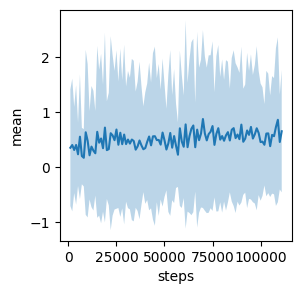

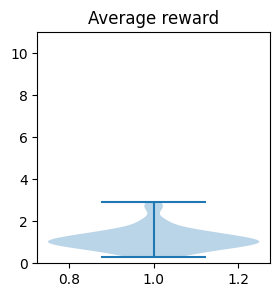

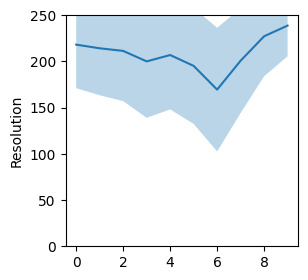

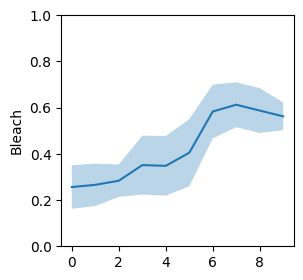

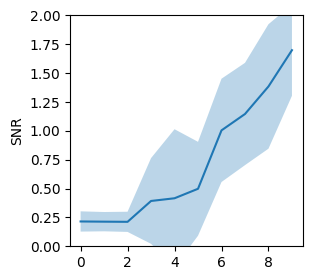

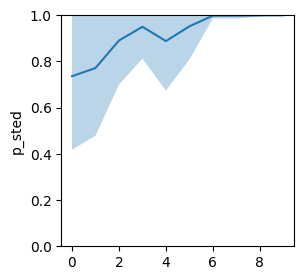

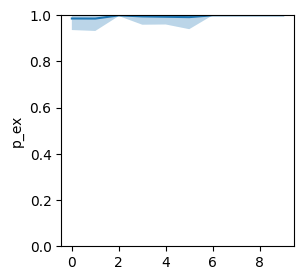

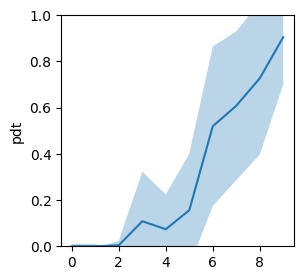

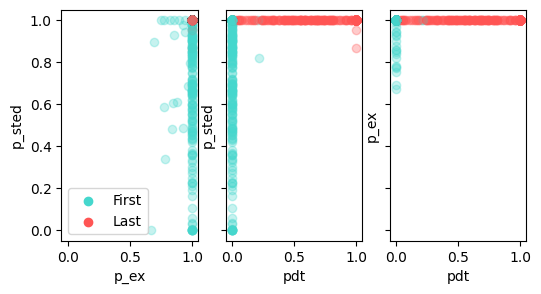

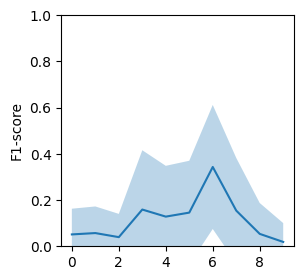

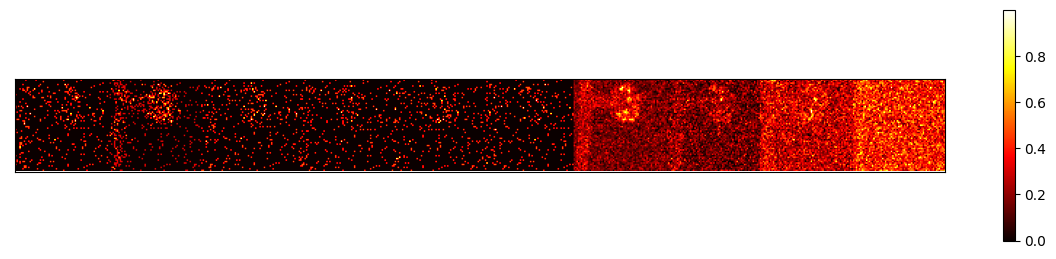

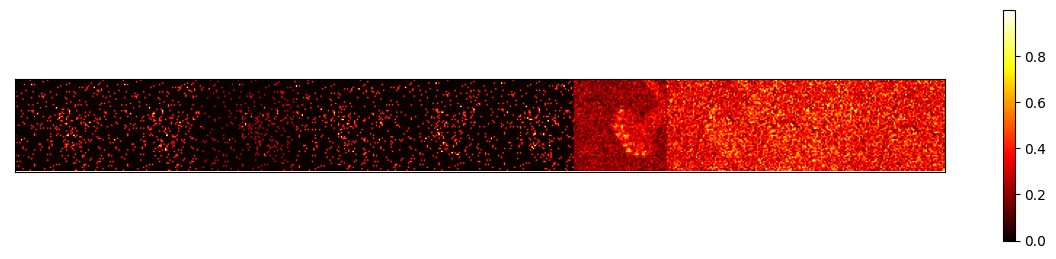

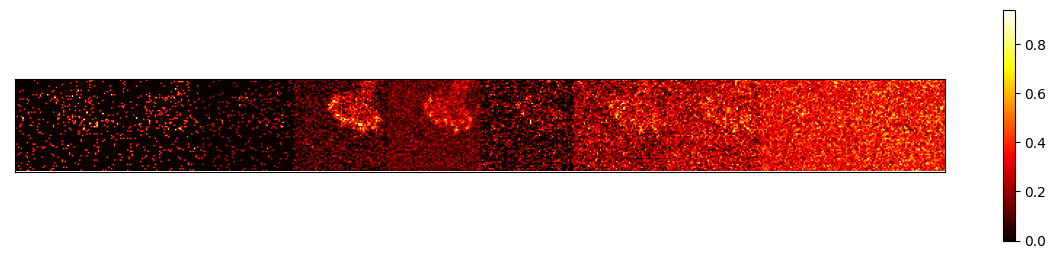

mid


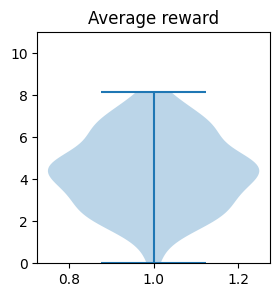

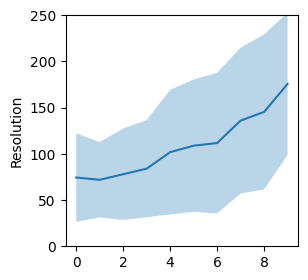

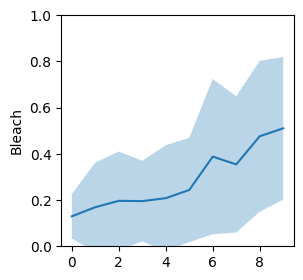

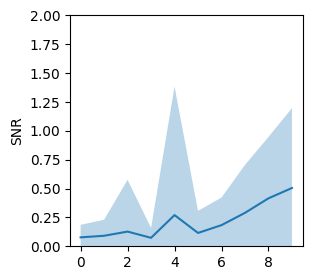

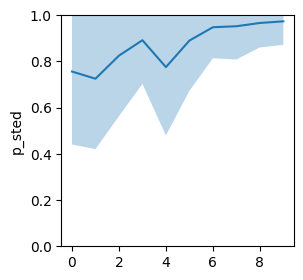

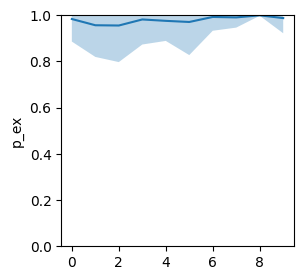

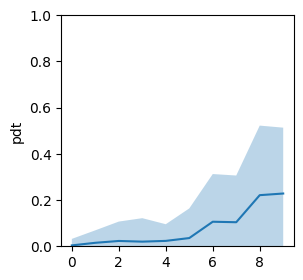

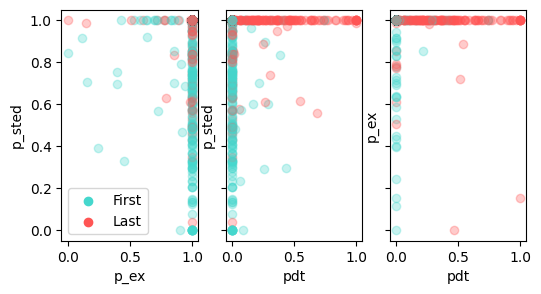

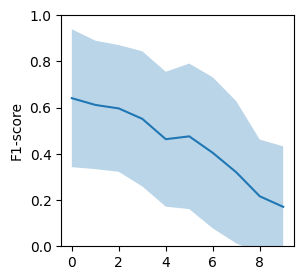

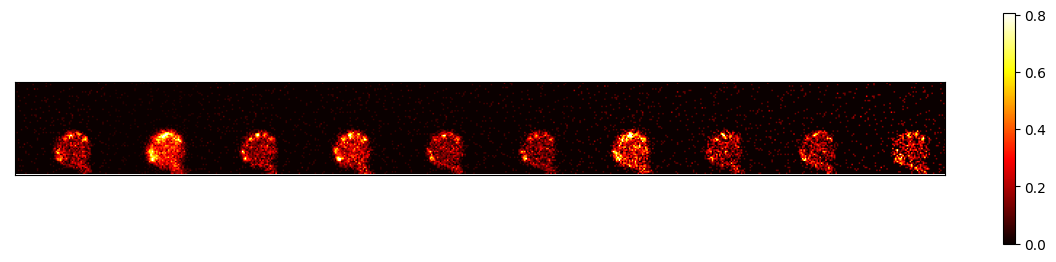

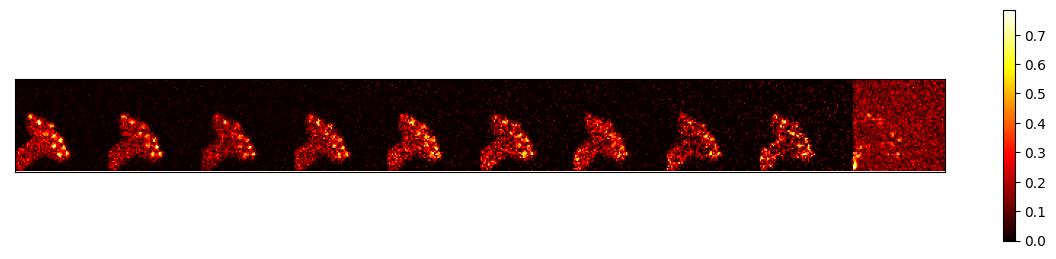

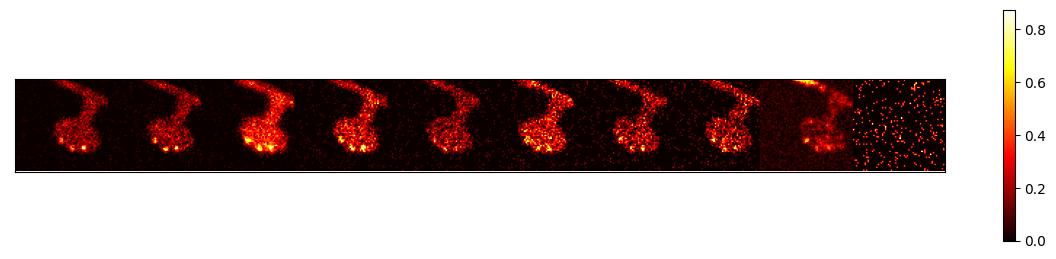

In [56]:
model_name = "20230131-122204_0b293779"
checkpoint = 100000
with open(os.path.join(PATH, model_name, "args.txt"), "r") as file:
    print(file.read())

SAVE = False

def load_scores(path, recursive=False):
    if recursive:
        df = pandas.DataFrame()
        for file in glob.glob(f"{path}*/scores.txt"):
            newdf = pandas.read_csv(file, sep="\t")
            df = pandas.concat((df, newdf))
        df.sort_values("steps", axis=0, inplace=True)
    else:
        df = pandas.read_csv(os.path.join(path, "scores.txt"), sep="\t")
    return df

smoothing_factor = 0
df = load_scores(os.path.join(PATH, model_name), recursive=True)
fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
if SAVE:
    savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"learning-curve"), save_white=True)

with h5py.File(os.path.join(PATH, model_name, "eval", f"stats_{checkpoint}_checkpoint.hdf5"), "r") as file:
    for bleach, records in file.items():
        print(bleach)

        fig, ax = plot_avg_reward(records, ylim=(0, 11))
        if SAVE:
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_reward"), save_white=True)

        figaxes = plot_objs_evolution(records, show_raw=False)
        if SAVE:
            for key, (fig, ax) in figaxes.items():
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_{key}_avg_objs_evolution"), save_white=True)

        figaxes = plot_actions_evolution(records, normalize=True)
        if SAVE:
            for key, (fig, ax) in figaxes.items():
                savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_{key}_avg_actions_evolution"), save_white=True)    
                            
        fig, axes = plot_actions_trajectories(records, normalize=True)
        if SAVE:
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"{bleach}_actions_trajectories"), save_white=True)
        
        fig, ax = plot_f1score_evolution(records)
        if SAVE:
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_avg_actions_evolution"), save_white=True)            

        example_images = show_acquire_images(records, normalize=True)
        for example in example_images:
            fig, ax = pyplot.subplots(figsize=(15, 3))
            im = ax.imshow(example["sted_image"], vmin=0, vmax=numpy.quantile(example["sted_image"],0.999), cmap="hot")
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            pyplot.colorbar(im, ax=ax)
        if SAVE:
            for i, example in enumerate(example_images):
                tifffile.imwrite(os.path.join(PATH, model_name, "panels", f"{bleach}_example-{i}_sted.tif"), (example["sted_image"] * 255).astype(numpy.uint8))

#         fig, ax = plot_last_reward(all_records[bleach], ylim=(0, 1))
#         if SAVE:
#             savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last_reward"), save_white=True)

#         figaxes = plot_last_image(all_records[bleach])
#         if SAVE:
#             for key, figaxes in figaxes.items():
#                 if isinstance(figaxes, tuple):
#                     fig, ax = figaxes
#                     savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}"), save_white=True)
#                 else:
#                     for action_name, (fig, ax) in zip(env.actions, figaxes):
#                         savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{bleach}_last-images_{key}_{action_name}"), save_white=True)            

        pyplot.show()

# LeaderBoard

In [ ]:
from gym_sted.leaderboard import LeaderBoard, plot_top

models = [
    "20211007-154135_7e528319",
    "20211007-154435_32206a95",
    "20211007-154435_267aeb16"
]

leaderboard = LeaderBoard(models, bleach="mid-bleach")
board = leaderboard.get_leaderboard()

In [ ]:
fig, ax = plot_top(
    board, "top1-articulation", models=models,
    xlabel="Steps", ylabel="Ranking (Objectives)", ylim=(0, 1), title="Top-1"
)
fig, ax = plot_top(
    board, "top3-articulation", models=models,
    xlabel="Steps", ylabel="Ranking (Objectives)", ylim=(0, 1), title="Top-3"
)
fig, ax = plot_top(
    board, "top1-f1", models=models,
    xlabel="Steps", ylabel="Ranking (F1-score)", ylim=(0, 1), title="Top-1"
)
fig, ax = plot_top(
    board, "top3-f1", models=models,
    xlabel="Steps", ylabel="Ranking (F1-score)", ylim=(0, 1), title="Top-3"
)
pyplot.show()

# Learning curves

In [ ]:
model_names = [
    "20210920-132845_f088da04",
    "20210921-062532_37aa3937",
    "20210921-062836_531503bd"
]
for model_name in model_names:

    smoothing_factor = 0
    df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
    fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)


In [ ]:
model_names = [
    ##############################
    # OLD PARAMETERS 
    ##############################
    # Ranking 
#     "20210903-114835_a3972c26", # easy

    ##############################
    # NEW PARAMETERS 
    ##############################

    # Ranking gamma of 0.1
#     "20210920-132845_f088da04", # easy

    # Ranking 
#     "20210914-122242_25874d69", # easy 
#     "20210920-073118_f964964b", # easy --resumed

    # Ranking last reward scaled
#     "20210917-084916_1c4633a7", # easy
#     "20210920-073010_2508ae35", # easy --resumed

    # Recurrent
#     "20210917-070841_c8ae7e94", # easy
#     "20210920-073010_b793f0e9", # easy --resumed

    # Contextual
#     "20210920-135352_c65727c3", # contextual f1-score
#     "20210921-062027_2169c34e", # contextual amelioration
]

# Plot learning curve
for model_name in model_names:
    smoothing_factor = 0
    df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
    fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
    ax.set_ylim(0, 10)
    pyplot.show()

# Expert demonstrations

In [ ]:
from gym_sted import defaults

import pickle, bz2 
path = "/home/anthony/Documents/gym-sted/gym_sted/prefnet/demonstrations/demonstrations.pbz2"
with bz2.open(path, "rb") as file:
    demonstrations = pickle.load(file)
actions = []
for demonstration in demonstrations:
    actions.append([info["action"] for info in demonstration])
actions = numpy.array(actions)
    
demonstrations = gym_sted.prefnet.load_demonstrations()
demonstrations = numpy.array(demonstrations)
demonstrations = demonstrations.reshape(5, 10, -1)


OBJS_YLIM_ = {
    "Resolution" : (0, 250),
    "Bleach" : (0, 1),
    "SNR" : (0, 0)
}

keys = ["Resolution", "Bleach", "SNR"]
figaxes = {key : pyplot.subplots(figsize=(3,3)) for key in keys}
for demonstration in demonstrations:
    for i, key in enumerate(keys):
        fig, ax = figaxes[key]
        ax.plot(demonstration[:, i])
for key in keys:
    fig, ax = figaxes[key]
    ax.set(
        ylim = OBJS_YLIM[key], ylabel=key, xlabel="Time steps"
    )
    
    savefig(fig, ax, f"./panels/expert-demonstrations_objective-{key}", save_white=True)
    
pyplot.show()

keys = ["p_sted", "p_ex", "pdt"]
figaxes = {key : pyplot.subplots(figsize=(3,3)) for key in keys}
for action in actions:
    for i, key in enumerate(keys):
        fig, ax = figaxes[key]
        act = (action[:, i] - action_spaces[key]["low"]) / (action_spaces[key]["high"] - action_spaces[key]["low"])
        ax.plot(act)
for key in keys:
    fig, ax = figaxes[key]
    ax.set(
        ylabel=key, xlabel="Time steps"
    )
    ax.set_ylim(0, 1)
    
    savefig(fig, ax, f"./panels/expert-demonstrations_parameter-{key}", save_white=True)
    
pyplot.show()



# Evolution across training steps

In [ ]:
from scipy.spatial import distance

def aggregate(scores, key):
    """
    Aggregates statistics from the scores
    
    :param scores: A `list` of repetitions
    :param key: A `str` of the metric to aggregate
    
    :returns : A `list` of scores per episode
    """
    output = []
    for episode_scores in scores:
        funcs = {"mean" : numpy.mean, "median" : numpy.median, "max" : numpy.max, "min" : numpy.min, "std": numpy.std}
        output.append({k : func([step_scores[key] for step_scores in episode_scores], axis=0) for k, func in funcs.items()})
    return output

def get_images(scores, image_objs):
    """
    Gets images that ave similar imaging objectives
    
    :param scores: A `list` of repetitions
    :param image_objs: A `list` of imaging objectives
    """
    def normalize_objs(objs):
        return numpy.array(objs) / numpy.array([250., 1., 1.])
    image_objs = normalize_objs(image_objs)
    if image_objs.ndim == 1:
        image_objs = image_objs[numpy.newaxis, :]

    acquired_objs, indices = [], []
    for e, episode_scores in enumerate(scores):
        for s, step_scores in enumerate(episode_scores):
            acquired_objs.append(step_scores["mo_objs"])
            indices.append((e, s))
    acquired_objs = normalize_objs(acquired_objs)
    
    distances = distance.cdist(image_objs, acquired_objs)
    nearest_images = numpy.argsort(distances, axis=1)[0, :10]

    images = []
    for n_image in nearest_images:
        e, s = indices[n_image]
        images.append(scores[e][s]["sted_image"])
    return images
    
experiments = {
    "f1-score" : [
        "20211025-112219_ed9c1925",
        "20211103-093512_1b2c4897",
        "20211103-093512_8b8e29e7",
        "20211103-093512_965beffe",
        "20211103-093512_b219b01f",
    ],
    "ranking" : [
        "20211007-153304_d018556e",        
        "20211103-093827_82ba2875",
        "20211103-093827_eb426aed",
        "20211103-093835_00d99eba",
        "20211103-093835_6ade7420",    
    ]
}
eval_checkpoint = [5000, 50000, 100000, 150000, 200000]
eval_folders = [f"eval_{ckpt}" for ckpt in eval_checkpoint]

image_objs = [
    (144, 0.99, 0.37),
    (85, 0.99, 0.32),
    (63, 0.99, 0.39),
    (57, 0.99, 0.46),
    (56, 0.99, 0.48)
]

BLEACH = "low-bleach"

scores = {exp : {folder : [] for folder in eval_folders} for exp in experiments.keys()}
images = {folder : [] for folder in eval_folders}
for experiment_name, model_names in tqdm(experiments.items(), desc="Experiments"):
    for model_name in tqdm(model_names, leave=False, desc="Models"):
#         with open(os.path.join(PATH, model_name, "args.txt"), "r") as file:
#             print(file.read())        
        for n, eval_folder in enumerate(tqdm(eval_folders, leave=False, desc="Eval")):
            with bz2.open(os.path.join(PATH, model_name, eval_folder, "stats.pbz2"), "rb") as file:
                all_records = pickle.load(file)       
                
            records = all_records[BLEACH]
            
            scores[experiment_name][eval_folder].append({
                key : aggregate(records, key) for key in ["f1-score", "mo_objs", "action"]
            })
            images[eval_folder].append({model_name : get_images(records, image_objs[n])})


In [ ]:
# Plots f1-score evolution
colors = ["tab:blue", "tab:orange"]

fig, ax = pyplot.subplots(figsize=(3,3))
new_ax = ax.twinx()
widths = 1 / (len(scores) + 1)
for i, (experiment_name, experiment_scores) in enumerate(scores.items()):
    points = []
    for c, checkpoint in enumerate(eval_checkpoint):
        for metric in ["median"]:
            data = [numpy.mean([s_[metric] for s_ in s["f1-score"]]) for s in experiment_scores[f"eval_{checkpoint}"]]
            parts = ax.violinplot(data, positions=[c + i * widths], widths=widths)
            for pc in parts['bodies']:
                pc.set_color(colors[i])
                pc.set_alpha(0.3)
    #         parts["cbars"].set_color(cmap(indices[0]))
    #         parts["cmins"].set_color(cmap(indices[0])) 
    #         parts["cmaxes"].set_color(cmap(indices[0]))
            parts["cbars"].set_color(colors[i])
            parts["cmins"].set_color(colors[i]) 
            parts["cmaxes"].set_color(colors[i])
            
#         for metric in ["min", "max"]:
#             data = [numpy.mean([s_[metric] for s_ in s["f1-score"]]) for s in experiment_scores[f"eval_{checkpoint}"]]
#             ax.scatter([c + i * widths], numpy.mean(data), color=colors[i], marker="_")  
        for metric in ["std"]:
            data = [numpy.mean([s_[metric] for s_ in s["f1-score"]]) for s in experiment_scores[f"eval_{checkpoint}"]]
            points.append((numpy.mean(data), numpy.std(data)))
    
    points = numpy.array(points)
    xs = numpy.arange(len(eval_checkpoint)) + widths / 2
    new_ax.plot(xs, points[:, 0], color=colors[i])
    new_ax.fill_between(xs, points[:, 0] - points[:, 1], points[:, 0] + points[:, 1], color=colors[i], alpha=0.3)    
                 
ax.set(
    ylabel=r"F$_1$-score", xticks=numpy.arange(len(eval_checkpoint)) + len(scores) * widths / 2 - widths / 2,
    xticklabels=[int(c / 1000) for c in eval_checkpoint], ylim=(0, 1), xlabel=r"Steps ($\times$10$^{3}$)"
)
fig.savefig("./panels/figure3/f1-score.pdf", transparent=True, bbox_inches="tight")
pyplot.show()

In [ ]:

objs = ["Resolution (nm)", "Photobleaching (%)", "SNR"]
figaxes = {
    key : pyplot.subplots(figsize=(3,3)) for key in objs
}
twin_axes = [ax.twinx() for key, (fig, ax) in figaxes.items()]
widths = 1 / (len(scores) + 1)
for i, (experiment_name, experiment_scores) in enumerate(scores.items()):
    points = []
    for c, checkpoint in enumerate(eval_checkpoint):
        for metric in ["median"]:
            data = numpy.array([numpy.mean([s_[metric] for s_ in s["mo_objs"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]])
            for n, key in enumerate(objs):
                print(key, data[:, n].mean())
                fig, ax = figaxes[key]
                parts = ax.violinplot(data[:, n], positions=[c + i * widths], widths=widths)

                for pc in parts['bodies']:
                    pc.set_color(colors[i])
                    pc.set_alpha(0.3)
        #         parts["cbars"].set_color(cmap(indices[0]))
        #         parts["cmins"].set_color(cmap(indices[0])) 
        #         parts["cmaxes"].set_color(cmap(indices[0]))
                parts["cbars"].set_color(colors[i])
                parts["cmins"].set_color(colors[i]) 
                parts["cmaxes"].set_color(colors[i])

#         for metric in ["min", "max"]:
#             data = numpy.array([numpy.mean([s_[metric] for s_ in s["mo_objs"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]])
#             for n, key in enumerate(objs):
#                 fig, ax = figaxes[key]
#                 ax.scatter([c + i * widths], numpy.mean(data[:, n]), color=colors[i], marker="_")                  
        for metric in ["std"]:
            data = [numpy.mean([s_[metric] for s_ in s["mo_objs"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]]
            points.append([numpy.mean(data, axis=0), numpy.std(data, axis=0)])
    
    xs = numpy.arange(len(eval_checkpoint)) + widths / 2
    points = numpy.array(points)
    for n, key in enumerate(objs):
        twin_axes[n].plot(xs, points[:, 0, n], color=colors[i])
        twin_axes[n].fill_between(xs, points[:, 0, n] - points[:, 1, n], points[:, 0, n] + points[:, 1, n], color=colors[i], alpha=0.3)
                                 
OBJ_PLOT_LIM = {
    "Resolution (nm)" : (0, 250),
    "Photobleaching (%)" : (0.99, 1.01),
    "SNR" : (0, 1)
}
for key in objs:   
    fig, ax = figaxes[key]
    ax.set(
        ylabel=key, xticks=numpy.arange(len(eval_checkpoint)) + len(scores) * widths / 2 - widths / 2,
        xticklabels=[int(c / 1000) for c in eval_checkpoint], ylim=OBJ_PLOT_LIM[key], xlabel=r"Steps ($\times$10$^{3}$)"
    )
    fig.savefig(f"./panels/figure3/{key}.pdf", transparent=True, bbox_inches="tight")
pyplot.show()

In [ ]:
objs = ["STED power", "Excitation power", "Pixel dwell time"]
figaxes = {
    key : pyplot.subplots(figsize=(3,3)) for key in objs
}
twin_axes = [ax.twinx() for key, (fig, ax) in figaxes.items()]
widths = 1 / (len(scores) + 1)
for i, (experiment_name, experiment_scores) in enumerate(scores.items()):
    points = []
    for c, checkpoint in enumerate(eval_checkpoint):
        for metric in ["median"]:
            data = numpy.array([numpy.mean([s_[metric] for s_ in s["action"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]])
            for n, key in enumerate(objs):
                print(key, data[:, n].mean())                
                fig, ax = figaxes[key]
                parts = ax.violinplot(data[:, n], positions=[c + i * widths], widths=widths)

                for pc in parts['bodies']:
                    pc.set_color(colors[i])
                    pc.set_alpha(0.3)
        #         parts["cbars"].set_color(cmap(indices[0]))
        #         parts["cmins"].set_color(cmap(indices[0])) 
        #         parts["cmaxes"].set_color(cmap(indices[0]))
                parts["cbars"].set_color(colors[i])
                parts["cmins"].set_color(colors[i]) 
                parts["cmaxes"].set_color(colors[i])
                
#         for metric in ["min", "max"]:
#             data = numpy.array([numpy.mean([s_[metric] for s_ in s["action"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]])
#             for n, key in enumerate(objs):
#                 fig, ax = figaxes[key]
#                 ax.scatter([c + i * widths], numpy.mean(data[:, n]), color=colors[i], marker="_")         
        for metric in ["std"]:
            data = [numpy.mean([s_[metric] for s_ in s["action"]], axis=0) for s in experiment_scores[f"eval_{checkpoint}"]]
            points.append([numpy.mean(data, axis=0), numpy.std(data, axis=0)])
    
    xs = numpy.arange(len(eval_checkpoint)) + widths / 2
    points = numpy.array(points)
    for n, key in enumerate(objs):
        twin_axes[n].plot(xs, points[:, 0, n], color=colors[i])
        twin_axes[n].fill_between(xs, points[:, 0, n] - points[:, 1, n], points[:, 0, n] + points[:, 1, n], color=colors[i], alpha=0.3)

OBJ_PLOT_LIM = {
    "STED power" : (0, 350e-3),
    "Excitation power" : (140e-6, 260e-6),
    "Pixel dwell time" : (9e-6, 20e-6)
}
for key in objs:   
    fig, ax = figaxes[key]
    ax.set(
        ylabel=key, xticks=numpy.arange(len(eval_checkpoint)) + len(scores) * widths / 2 - widths / 2,
        xticklabels=[int(c / 1000) for c in eval_checkpoint], ylim=OBJ_PLOT_LIM[key], xlabel=r"Steps ($\times$10$^{3}$)"
    )
    fig.savefig(f"./panels/figure3/{key}.pdf", transparent=True, bbox_inches="tight")
pyplot.show()

# Visualize images

In [ ]:
from skimage import io

keep_model = "20211025-112219_ed9c1925"

for i, (eval_folder, extracted_images) in enumerate(images.items()):
    stack = []
    for images_per_model in extracted_images:
        for model_name, stack_images in images_per_model.items():
            if model_name != keep_model:
                continue
            stack_images = numpy.array(stack_images)
            print(stack_images.shape)

            fig, axes = pyplot.subplots(1, len(stack_images), figsize=(15, 3))
            for ax, im in zip(axes.ravel(), stack_images):
                ax.imshow(im, cmap="hot", vmin=0, vmax=20)
            pyplot.show()
            
#     for extracted_image in extracted_images:
#         extracted_image = extracted_image[i]
#         stack.append(extracted_image)
#     stack = numpy.array(stack)
    
            io.imsave(f"./panels/figure3/example-image_{eval_folder}.tif", stack_images.astype(numpy.uint16), check_contrast=False)